## Running lstchain_dl1ab.py on real data

(see also https://github.com/cta-observatory/2022_01_lstchain_school/blob/main/DL1a_to_DL1b/explore_dl1_MC.ipynb)

Suggested input file: `/fefs/aswg/data/real/DL1/20201120/v0.8.2.post1/tailcut84/dl1_LST-1.Run02977.0122.h5`
<br>(available also in `/fefs/aswg/workspace/analysis-school-2022/DL1ab` for download)

The file is a standard DL1 file, produced using the lstchain_dl1ab.py script with the pedestal-cleaning option and the following configuration in `/fefs/aswg/workspace/analysis-school-2022/DL1ab/config/dl1ab_realdata.json` :

```
{
  "tailcut": {
    "picture_thresh":8,
    "boundary_thresh":4,
    "keep_isolated_pixels":false,
    "min_number_picture_neighbors":2,
    "use_only_main_island":false,
    "delta_time": 2
  },
  "tailcuts_clean_with_pedestal_threshold": {
    "picture_thresh":8,
    "boundary_thresh":4,
    "sigma":2.5,
    "keep_isolated_pixels":false,
    "min_number_picture_neighbors":2,
    "use_only_main_island":false,
    "delta_time": 2
  },
  "dynamic_cleaning": {
    "apply": true,
    "threshold": 267,
    "fraction_cleaning_intensity": 0.03
  }
}
```

If you execute (in the directory where you want to get the output):

```
lstchain_dl1ab -f /fefs/aswg/data/real/DL1/20201120/v0.8.2.post1/tailcut84/dl1_LST-1.Run02977.0122.h5 -o ./dl1_LST-1.Run02977.0122_new.h5 -c /fefs/aswg/workspace/analysis-school-2022/DL1ab/config/dl1ab_realdata.json --pedestal-cleaning True
```

You will obtain a DL1 file with identical contents (since the selected cleaning is identical to the standard one). 

You can try instead to run it without the pedestal cleaning (False is the default for that option). We can also remove the images from the output with the `--no-image` option:

```
lstchain_dl1ab -f /fefs/aswg/data/real/DL1/20201120/v0.8.2.post1/tailcut84/dl1_LST-1.Run02977.0122.h5 -o ./dl1_LST-1.Run02977.0122_new.h5 -c /fefs/aswg/workspace/analysis-school-2022/DL1ab/config/dl1ab_realdata.json --no-image True
```

In that case the image parameters will not be identical (and the file will be much less bulky due to the removal of the images). In the rest of the notebook we use the original file and the one produced with the command above to have a look at the files' contents and do some comparisons. 


In [1]:
import glob
from ctapipe.io import read_table
from astropy.table import vstack, Table
from lstchain.io.io import dl1_params_lstcam_key, dl1_images_lstcam_key
from lstchain.io.io import dl1_params_tel_mon_ped_key, dl1_params_tel_mon_cal_key, dl1_params_tel_mon_flat_key
import matplotlib.pyplot as plt
import numpy as np

from ctapipe.visualization import CameraDisplay
from ctapipe.coordinates import EngineeringCameraFrame
from ctapipe.instrument import SubarrayDescription
from ctapipe.containers import EventType

%matplotlib inline

In [2]:
# File to explore (a short data subrun):
dl1_file = "/fefs/aswg/data/real/DL1/20201120/v0.8.2.post1/tailcut84/dl1_LST-1.Run02977.0122.h5"
# The file is also included in the data for download, in /fefs/aswg/workspace/analysis-school-2022/DL1ab

# File processed with DL1ab (use here the file produced by you!):
dl1_file_b = "/fefs/aswg/workspace/abelardo.moralejo/2022_LST_school/DL1b/dl1_LST-1.Run02977.0122_new.h5"


In [3]:
# Read useful instrument configuration information:
subarray_info = SubarrayDescription.from_hdf(dl1_file)
print(subarray_info.tels)
# Obtain camera geometry:
camgeom = subarray_info.tel[1].camera.geometry
# Transform camera geometry to the more usual "engineering camera frame":
camgeom = camgeom.transform_to(EngineeringCameraFrame())
camgeom

{1: TelescopeDescription(type=LST, name=LST, optics=LST, camera=LSTCam)}


CameraGeometry(camera_name='LSTCam', pix_type=<PixelShape.HEXAGON: 'hexagon'>, npix=1855, cam_rot=-1.5707963267948966 rad, pix_rot=-3.3317113690095352 rad)

In [4]:
# Where the image parameters (DL1b) are stored in the hdf5 files:
print(dl1_params_lstcam_key)

/dl1/event/telescope/parameters/LST_LSTCam


In [5]:
# Read parameters table from file:
dl1_parameters = read_table(dl1_file, dl1_params_lstcam_key)
dl1_parameters_b = read_table(dl1_file_b, dl1_params_lstcam_key)

In [6]:
# Check column names:
print(dl1_parameters.columns)

<TableColumns names=('obs_id','event_id','intensity','log_intensity','x','y','r','phi','length','length_uncertainty','width','width_uncertainty','psi','skewness','kurtosis','time_gradient','intercept','leakage_intensity_width_1','leakage_intensity_width_2','leakage_pixels_width_1','leakage_pixels_width_2','n_pixels','concentration_cog','concentration_core','concentration_pixel','n_islands','alt_tel','az_tel','calibration_id','dragon_time','ucts_time','tib_time','ucts_jump','mc_type','wl','tel_id','tel_pos_x','tel_pos_y','tel_pos_z','trigger_type','ucts_trigger_type','trigger_time','event_type')>


Description of parameters in\
https://github.com/cta-observatory/cta-lstchain/blob/master/lstchain/io/lstcontainers.py

Notes: 
- these DL1 files are provisional and LST-specific. Eventually we will use the agreed DL1 model already implemented in ctapipe:\
    https://cta-observatory.github.io/ctapipe/data_models/dl1.html#dl1-data-model


- there are some parameters which do not change event-wise, yet they are written in the events table for convenience (tel_id, tel_pos_x, y, z)

- Note: some parameters don't have their units in the table (if not mentioned below, they are adimensional):
 - timestamps, like dragontime (currently the most reliable one) are in seconds (unix timestamps)


In [7]:
dl1_parameters

obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,length_uncertainty,width,width_uncertainty,psi,skewness,kurtosis,time_gradient,intercept,leakage_intensity_width_1,leakage_intensity_width_2,leakage_pixels_width_1,leakage_pixels_width_2,n_pixels,concentration_cog,concentration_core,concentration_pixel,n_islands,alt_tel,az_tel,calibration_id,dragon_time,ucts_time,tib_time,ucts_jump,mc_type,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,ucts_trigger_type,trigger_time,event_type
,,,,m,m,m,rad,deg,deg,deg,deg,rad,,,,,,,,,,,,,,rad,rad,,,,,,,,,m,m,m,,,,
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,int64,float64,float64,float64,int64,float64,float64,int64,float64,int64,int64,bool,int64,float64,int64,float64,float64,float64,int64,uint8,float64,int64
2977,6466001,60.31676197052002,1.78043801893464,0.10901472329658923,0.04775726128315388,0.1190166622817971,0.4128978602316072,0.08207166220287763,0.004590456418642578,0.033888700071936215,0.0033730032546496775,0.6310166218366219,0.597496821585862,1.7547840195848348,-23.402530093020598,13.104528542296269,0.0,0.0,0.0,0.0,4,0.7445138686978954,0.16967902630317097,0.38926306821750994,1,1.193516243741592,4.498465955792359,0,1605932268.0283875,0,0,False,-9999,0.4129157365187552,1,50.0,50.0,16.0,-1,1,1605932268.0283875,32
2977,6466002,205.97580671310425,2.3138162124660737,-0.48201156932872874,0.07405030596866802,0.4876664851933104,2.989156781300496,0.12422759978000034,0.004199190451006014,0.04992858163688875,0.0018311051122040648,0.6752005431697004,0.14139905808960507,1.9413904757485554,0.7930468885504515,15.479861586429001,0.0,0.0,0.0,0.0,11,0.4664538542488316,0.12004961309437513,0.17343045054308234,1,1.1935162273569095,4.498465973269354,0,1605932268.028638,0,0,False,-9999,0.4019116212914205,1,50.0,50.0,16.0,-1,1,1605932268.028638,32
2977,6466003,117.32553911209106,2.069392558476847,0.5546306578024086,-0.01790572800232233,0.5549196173047278,-0.03227284829580462,0.06666946713196024,0.004053282941285911,0.04192696977508571,0.0027122688367761387,0.23860491115933732,0.08083260227938843,2.7346506898765925,-9.508022086920615,15.161511689537619,0.0,0.0,0.0,0.0,6,0.800007643990677,0.3670287646888793,0.3670287646888793,1,1.1935162166366458,4.498465984704302,0,1605932268.0288017,0,0,False,-9999,0.628877957778602,1,50.0,50.0,16.0,-1,1,1605932268.0288017,32
2977,6466004,240.27883005142212,2.3807155086446845,0.2350927845487761,0.3752449956152994,0.4428063053765419,1.0111156520598923,0.09140186969538998,0.0038109857444860278,0.06525016343683888,0.002694723828158788,-1.3723626595051714,-0.583792719448394,2.6708568889771485,3.5779866538378293,14.575948749170522,0.0,0.0,0.0,0.0,11,0.5267860618772177,0.17082423904943483,0.17082423904943483,1,1.1935162145456482,4.498465986934699,0,1605932268.0288336,0,0,False,-9999,0.7138818550615464,1,50.0,50.0,16.0,-1,1,1605932268.0288336,32
2977,6466005,61.43503427505493,1.7884161049059881,0.59339754279931,-0.1966134989761881,0.6251219975172194,-0.3199511659879921,0.0641479949466249,0.0038156353077172414,0.043400842541463286,0.0011866824223200993,0.7669800003668156,0.17493972274892608,1.869447333038227,-11.815397606626135,12.203192711111328,0.0,0.0,0.0,0.0,5,0.7459874623758926,0.0,0.3464578648612347,1,1.1935161930895164,4.4984660098212395,0,1605932268.0291615,0,0,False,-9999,0.6765734882960887,1,50.0,50.0,16.0,-1,1,1605932268.0291615,32
2977,6466006,263.60498571395874,2.4209536200630346,-0.9163847082699118,-0.46779838557225956,1.0288810733485885,-2.6695942295148267,0.17547838858733886,0.00565565684432748,0.05920980737791896,0.0019132895354040805,-1.0665050352263137,-0.21125780764312327,2.095291519026632,0.4187970192368047,12.503836573890288,0.31783152,0.94931865,0.0037735849056603774,0.007547169811320755,16,0.3409456069641712,0.3512084245952274,0.18873099431729212,1,1.1935161863015766,4.498466017061709,0,1605932268.0292652,0,0,False,-9999,0.33741843

## Check how many events of each type

In [31]:
# Note: a full subrun should have a total of 53000 events. We have chosen an incomplete subrun (last of a run)
# to avoid a too large file.

cosmics = dl1_parameters['event_type'] == EventType.SUBARRAY.value
pedestals = dl1_parameters['event_type'] == EventType.SKY_PEDESTAL.value
flatfield = dl1_parameters['event_type'] == EventType.FLATFIELD.value


print('Cosmics (showers):', np.sum(cosmics))
print('Interleaved pedestals:', np.sum(pedestals))
print('Interleaved flatfield:', np.sum(flatfield))

Cosmics (showers): 14609
Interleaved pedestals: 272
Interleaved flatfield: 270


In [33]:
valid_image = dl1_parameters['intensity'] > 0 # Image survived image and was parametrized
print("Events which survived cleaning:")
print('Cosmics (showers):', np.sum(cosmics & valid_image))
print('Interleaved pedestals:', np.sum(pedestals & valid_image))
print('Interleaved flatfield:', np.sum(flatfield & valid_image))

Events which survived cleaning:
Cosmics (showers): 12106
Interleaved pedestals: 2
Interleaved flatfield: 270


As expected, very few interleaved pedestals survive the cleaning stage, since they contain no shower. Obviously, all of the flatfield events survive, and most of the cosmics. Below we plot the distribution of the intensity parameter (total light in cleaned image) for the different types of events.

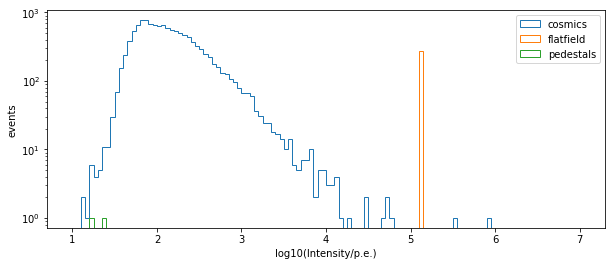

In [47]:
plt.figure(figsize=(10,4))
plt.hist(np.log10(dl1_parameters['intensity'][cosmics & valid_image]), 
         bins=120, range=(1, 7), histtype='step', log=True, label='cosmics')
plt.hist(np.log10(dl1_parameters['intensity'][flatfield & valid_image]), 
         bins=120, range=(1, 7), histtype='step', log=True, label='flatfield')
plt.hist(np.log10(dl1_parameters['intensity'][pedestals & valid_image]), 
         bins=120, range=(1, 7), histtype='step', log=True, label='pedestals')
plt.legend()
plt.xlabel('log10(Intensity/p.e.)')
plt.ylabel('events')
plt.show()

## Read images table from file:

In [8]:
dl1_images = read_table(dl1_file, dl1_images_lstcam_key)
dl1_images

obs_id,event_id,image [1855],peak_time [1855],image_mask [1855],tel_id,selected_gain_channel [1855]
int64,int64,float32,float32,bool,int64,int8
2977,6466001,8.029814 .. 3.8200996,26.161394 .. 19.955288,False .. False,1,0 .. 0
2977,6466002,2.5008557 .. 0.839407,14.535673 .. 33.37127,False .. False,1,0 .. 0
2977,6466003,3.137565 .. -0.65831435,8.347558 .. 10.692666,False .. False,1,0 .. 0
2977,6466004,2.7387774 .. 2.0303104,7.7958727 .. 10.707547,False .. False,1,0 .. 0
2977,6466005,3.115936 .. 3.2274456,9.542418 .. 29.5477,False .. False,1,0 .. 0
2977,6466006,3.9219625 .. 6.491641,30.894434 .. 12.745644,False .. False,1,0 .. 0
2977,6466007,4.316024 .. 2.4363642,31.924145 .. 25.686224,False .. False,1,0 .. 0
2977,6466008,4.012534 .. 2.7193806,2.2882273 .. 2.8519177,False .. False,1,0 .. 0
2977,6466009,4.4245005 .. 1.264685,2.3073056 .. 32.110443,False .. False,1,0 .. 0


The images table stores, for each event and pixel, the charge in p.e. ("image"), the time of the light arrival in ns ("peak time"), the selected gain channel and whether the pixel survived cleaning or not ("image_mask"). The table entries corespond to the entries in the parameters table, so you can use the latter to select events in the former and vice versa. An example is shown below.

## Plot a bright image:

In [9]:
import astropy.units as u
# Locate first table entry for which n_pixels (after cleaning) is larger than 100, 
# is more or less centered (c.o.g. within 0.5 m of the camera center), and is a cosmic (="SUBARRAY"):
mask = ((dl1_parameters['n_pixels']>100) & 
        (dl1_parameters['r']<0.5*u.m) &
        (dl1_parameters['event_type']==EventType.SUBARRAY.value)
       )
index = np.where(mask)[0][0]

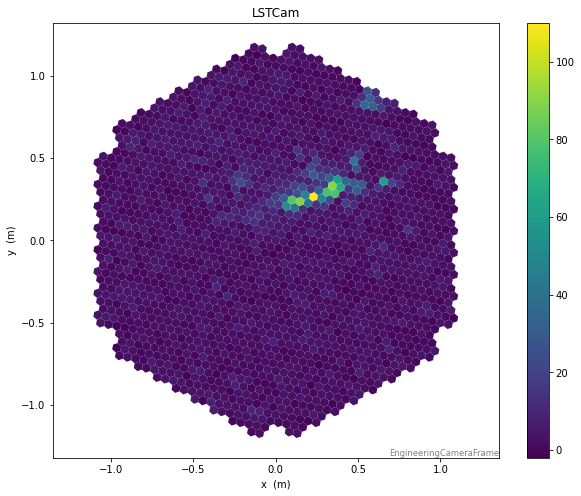

In [10]:
plt.figure(figsize=(10,8))
camdisplay = CameraDisplay(camgeom, dl1_images['image'][index])
camdisplay.add_colorbar()
plt.show()

## Read calibration monitoring tables from the file:

The interleaved pedestal and calibration events are processed to obtain a few monitoring values which are stored in tables in the DL1 hdf5 file

In [11]:
monitor_ped = read_table(dl1_file, dl1_params_tel_mon_ped_key)
monitor_cal = read_table(dl1_file, dl1_params_tel_mon_cal_key)

In [12]:
monitor_ped

tel_id,calibration_id,pedestal_id,flatfield_id,n_events,sample_time,sample_time_min,sample_time_max,"charge_mean [2,1855]","charge_median [2,1855]","charge_std [2,1855]","charge_median_outliers [2,1855]","charge_std_outliers [2,1855]"
,,,,,s,s,s,,,,,
int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,bool,bool
1,0,0,0,10000,5.855929398146387e-05,1605914727.886898,1605914738.005944,-0.6167152492240071 .. 1.82128215636611,-16.498023986816406 .. 1.6406139731407166,215.4279449423478 .. 22.085835322441405,False .. False,False .. False
1,1,1,1,272,1.6377969907416245e-05,1605932305.0371635,1605932307.8672767,-27.15211570679265 .. 9.22186339159003,-39.218183517456055 .. 8.702023029327393,175.4190290990653 .. 23.04061641093008,False .. False,False .. False


In [13]:
monitor_cal

tel_id,calibration_id,pedestal_id,flatfield_id,time,time_min,time_max,"dc_to_pe [2,1855]","pedestal_per_sample [2,1855]","time_correction [2,1855]","n_pe [2,1855]","unusable_pixels [2,1855]"
,,,,s,s,s,,,ns,,
int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,bool
1,0,0,0,5.8749781249978206e-05,1605914727.8863301,1605914738.0382924,0.012424848962207658 .. 0.21939704550164338,-1.3748353322347004 .. 0.13671783109505972,-1.0414247512817383 .. 0.31426048278808594,89.26865640692802 .. 75.42959411381048,False .. False
1,1,1,1,1.643672858797629e-05,1605932305.0364084,1605932307.8766751,0.011703565768605153 .. 0.20360785190909023,-3.2681819597880044 .. 0.7251685857772827,0.09217691421508789 .. 0.1853485107421875,78.94025567012528 .. 75.87563163422837,False .. False


In the monitoring tables above, calibration_id = 0 indicates the values were obtained from the dedicated calibration (flatfield + pedestal) run taken before observation, while calibration_id > 0 corresponds to values obtained with the interleaved pedestal and flafield events.

In the parameters table, calibration_id (currently always = 0) indicates which calibration constants are used to calibrate the events (currently, always those from the dedicated calibration run)

The 2D arrays in the monitoring tables are all Ngains * Npixels, with Ngains always = 2 (high and low gain)

## Display the standard deviation of pixel charge (in photoelectrons) calculated from interleaved pedestals:

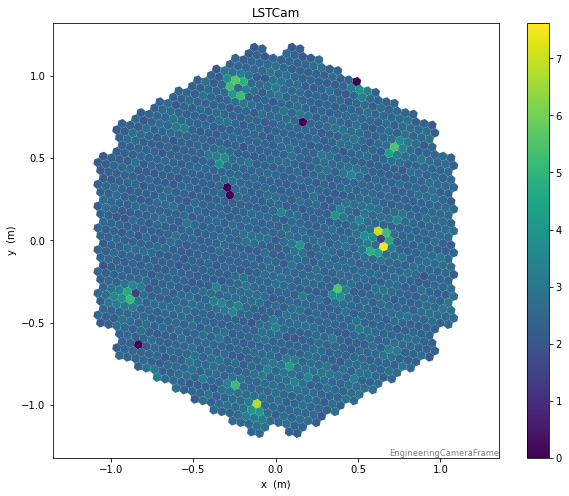

In [14]:
# The first index below means 0='original calibration from dedicated run'  1='calibration from interleaved events' 
# The second index (=0) index selects the high-gain values

# We use the conversion factors dc_to_pe from the original calibration, since for pixels illuminated by 
# stars the calibration fails sometimes (and this is an issue, because stars may produce a decrease of PMT high 
# voltage, hence of gain, and conversion factors should be recalculated)


hg_stdev_counts = monitor_ped['charge_std'][1][0]
hg_counts_to_pe = monitor_cal['dc_to_pe'][0][0]

plt.figure(figsize=(10,8))
camdisp = CameraDisplay(camgeom, hg_stdev_counts*hg_counts_to_pe)
camdisp.add_colorbar()
plt.show()

The "hot" and "cold" pixels in the display above are mostly due to stars, which make pixels noisy, and eventually may reduce the high-voltage (hence the gain) of some of them.

In the application of the DL1a to DL1b step to real data, the monitoring pedestal info for the high gain, as determined from the interleaved pedestal events within a subrun, is used to apply the "pedestal cleaning". The core pixel threshold is raised to 2.5 times the standard deviation above the mean charge (both mean and std dev evaluated for interleaved pedestals), if that turns out to be larger than the standard "base" picture threshold (8 p.e.). 

This cleaning, which aims at reducing the effect of noise from stars, is the reason why for the real data the step DL1a to DL1b has to be done after the R0 to DL1 stage, because only after the latter is the needed information from the interleaved events available. In MC we do not have stars or real data, so the image cleaning can be done straightaway in the R0 to DL1 stage. This is of course one of the possible sources of disagreement between data and MC, and the base cleaning (picture: 8 p.e., boundary: 4 p.e.) was chosen such that not too many pixels get increased cleaning thresholds because of stars (in other words: the base cleaning levels must be high enough so that not too many pixels have ped_mean + 2.5 * pedestal_std_dev > 8 p.e.)

Below we can see the effect of stars in the distribution of the centers of gravity of shower images:

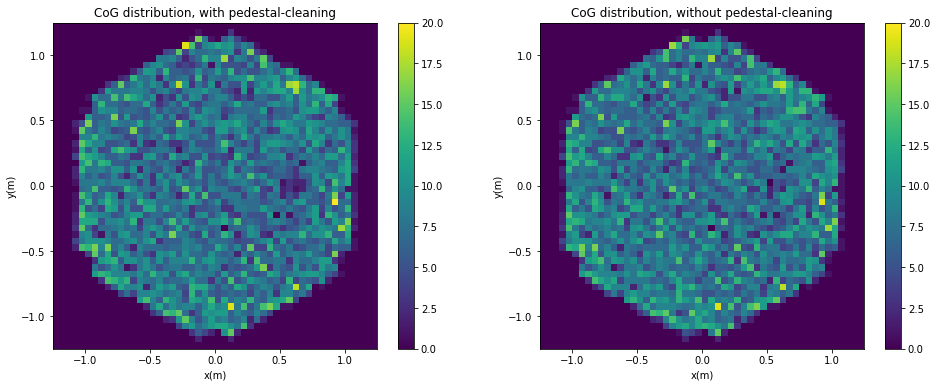

In [15]:
fig = plt.figure(figsize=(16, 6))

# select cosmics events:
cosmics_mask = (dl1_parameters['event_type']==EventType.SUBARRAY.value)

# z-axis end of scale:
zmax = 20

# Note: coordinates of the image center of gravity, (x,y), are in the ctapipe.coordinates.CameraFrame 
# (different from the EngineeringCameraFrame displayed above). Small hack: relation between the two systems
# is just x => -y;  y => -x:

ax = fig.add_subplot(1, 2, 1)
ax.set_title('CoG distribution, with pedestal-cleaning')
plt.hist2d(-dl1_parameters['y'][cosmics_mask], 
           -dl1_parameters['x'][cosmics_mask], 
           bins=(50,50), range=((-1.25, 1.25),(-1.25, 1.25)),
           vmax=zmax)
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.colorbar()

ax = fig.add_subplot(1, 2, 2)
ax.set_title('CoG distribution, without pedestal-cleaning')
plt.hist2d(-dl1_parameters_b['y'][cosmics_mask], 
           -dl1_parameters_b['x'][cosmics_mask], 
           bins=(50,50), range=((-1.25, 1.25),(-1.25, 1.25)), 
           vmax=zmax)
plt.xlabel('x(m)')
plt.ylabel('y(m)')

plt.colorbar()
plt.show()

The pedestal cleaning (left) introduces a hole in the distribution of CoGs at the position of the brightest star, because it increases the cleaning picture threshold of the pixels illuminated by it. The effect is not very strongly visible because of the limited statistics and also because the base cleaning levels (8 and 4 p.e.) are not too low. As mentioned above, it would be a problem for the good matching of data and MC if the effect of the pedestal-cleaning was large (more holes), since we do not simulate stars in the MC. A much bigger difference between the two approaches would be seen if you re-produce both DL1 files, using lstchain_dl1ab.py, with 6 and 3 p.e. cleaning thresholds (may be done as an exercise).

In [16]:
print('Number of successfully reconstructed images')
print('  With pedestal cleaning:', np.sum(dl1_parameters['intensity']>0))
print('  Without pedestal cleaning:', np.sum(dl1_parameters_b['intensity']>0))

Number of successfully reconstructed images
  With pedestal cleaning: 12427
  Without pedestal cleaning: 12555


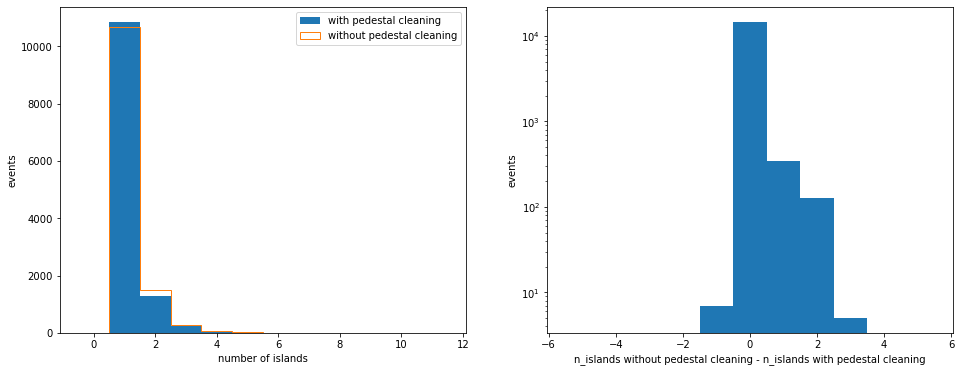

In [17]:
fig = plt.figure(figsize=(16, 6))

fig.add_subplot(1, 2, 1)
plt.hist(dl1_parameters['n_islands'], bins=12, range=(-0.5,11.5), label='with pedestal cleaning')
plt.hist(dl1_parameters_b['n_islands'], bins=12, range=(-0.5,11.5), histtype='step', label='without pedestal cleaning')
plt.xlabel('number of islands')
plt.ylabel('events')
plt.legend()

fig.add_subplot(1, 2, 2)
plt.hist(dl1_parameters_b['n_islands']-dl1_parameters['n_islands'], bins=11, range=(-5.5,5.5), log=True)
plt.xlabel('n_islands without pedestal cleaning - n_islands with pedestal cleaning')
plt.ylabel('events')

plt.show()

The islands of an image are the disconnected groups of pixels which survive the image cleaning. When bright stars are present spurious islands may form (besides the true shower image)and spoil the shower image reconstruction. There may also be fully spurious images produced by the stars, with no true shower on the camera. In the plot above we see the effect of the pedestal cleaning, aimed at solving those potential issues, in the distribution of the number of islands.

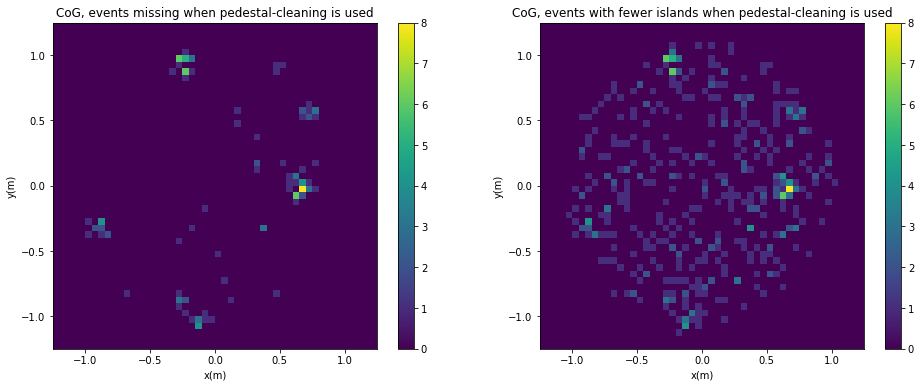

In [18]:
# Here we check where are the CoGs of the events which are different between the two reconstructions:

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('CoG, events missing when pedestal-cleaning is used')
mask = np.isnan(dl1_parameters['intensity']) & (dl1_parameters_b['intensity']>0)
plt.hist2d(-dl1_parameters_b['y'][cosmics_mask & mask], 
           -dl1_parameters_b['x'][cosmics_mask & mask], 
           bins=(50,50), range=((-1.25, 1.25),(-1.25, 1.25)))
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.colorbar()

ax = fig.add_subplot(1, 2, 2)
ax.set_title('CoG, events with fewer islands when pedestal-cleaning is used')
mask = dl1_parameters['n_islands'] < dl1_parameters_b['n_islands']
plt.hist2d(-dl1_parameters_b['y'][cosmics_mask & mask], 
           -dl1_parameters_b['x'][cosmics_mask & mask], 
           bins=(50,50), range=((-1.25, 1.25),(-1.25, 1.25)))
plt.xlabel('x(m)')
plt.ylabel('y(m)')

plt.colorbar()

plt.show()

In the plot above on the left side, one can see that the events that "disappeared" when introducing the pedestal-cleaning option are mostly clustered around the stars, which makes sense: they were either spurious events or small shower images that were too close to the affected pixels.
On the right side, we see the CoG distribution of events whose number of islands became smaller with the introduction of the pedestal cleaning. Besides events close to the stars, we see a wide distribution, most likely of genuine shower events which had a spurious island that got removed by the pedestal cleaning. 

Below we make an event-wise comparison of the Width parameter obtained with both types of cleaning (each dot is one event). We see some cases of very large differences, in which the pedestal cleaning probably removed a spurious island which was far from the genuine shower image.

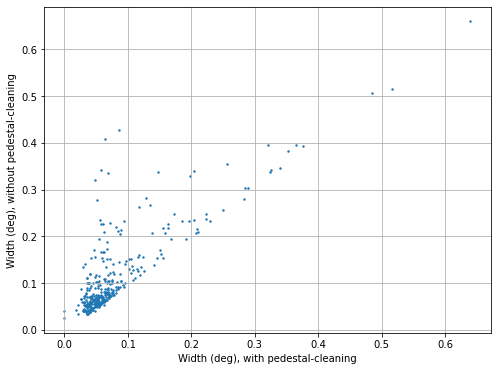

In [20]:
plt.figure(figsize=(8,6))
mask = dl1_parameters_b['n_islands'] > dl1_parameters['n_islands']
plt.scatter(dl1_parameters['width'][mask], dl1_parameters_b['width'][mask], s=2)
plt.xlabel('Width (deg), with pedestal-cleaning')
plt.ylabel('Width (deg), without pedestal-cleaning')
plt.grid()
plt.show()

## Additional exercises

You can try to make stronger modifications of the cleaning settings, like lowering the cleaning thresholds to 6, 3 p.e., or raising them, and check the effect on the different image parameters